In [785]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Callable, Type


In [786]:
torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')
torch.get_default_device()

device(type='cuda', index=0)

In [787]:
nerf_data = np.load("./data/nerf-data/tiny_nerf_data.npz")
nerf_data.keys()

KeysView(NpzFile './data/nerf-data/tiny_nerf_data.npz' with keys: images, poses, focal)

In [788]:
input_images = torch.from_numpy(nerf_data["images"]).to(device=torch.get_default_device())
"""Training images"""
input_poses = torch.from_numpy(nerf_data["poses"]).to(device=torch.get_default_device())
"""Camera-to-world transformation matrices"""
focal_length = torch.from_numpy(nerf_data["focal"]).to(device=torch.get_default_device())
"""Distance from camera to image plane"""

image_res = input_images.shape[1:-1]

clip_near = 0.1
clip_far = 5.0

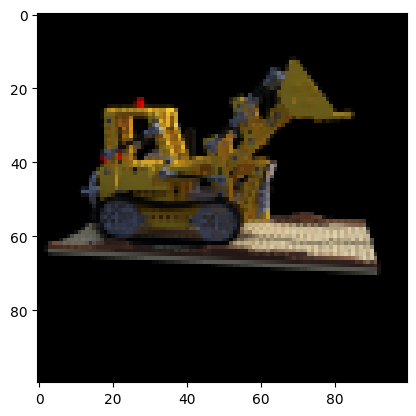

"Pose : tensor([[ 0.2079,  0.1652, -0.9641, -3.8864],\n        [-0.9781,  0.0351, -0.2049, -0.8261],\n        [ 0.0000,  0.9856,  0.1689,  0.6810],\n        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')"

In [789]:
sample_image_idx = input_images.shape[0] // 2
test_image, test_pose = input_images[sample_image_idx], input_poses[sample_image_idx]

plt.imshow(test_image.cpu().numpy())
plt.show()
f"Pose : {test_pose}"

\begin{align}
\gamma(x,y) =&[\sin(\pi x), \cos(\pi x),\sin(\pi y), \cos(\pi y), \\
&\sin(2 \pi x), \cos(2 \pi x),\sin(2 \pi y), \cos(2 \pi y), \\
&\ldots\\
&\sin(2^{L-1}\pi x), \cos(2^{L-1}\pi x),\sin(2^{L-1}\pi y), \cos(2^{L-1}\pi y)] \in \mathbb{R}^{4*L}
\end{align}

In [790]:
def positional_encoding(v : torch.Tensor, l : int = 6):
    # TESTED : OK
    # TODO : This is not ideal, ideally we implement this https://bmild.github.io/fourfeat/ 
    """
    Apply positional encoding (Gamma) to the input tensor
    Source : https://bmild.github.io/fourfeat/

    l - Low l over-smooths, high l over-fits
    """
    n = v.size
    
    powers = 2 ** torch.arange(l)  # Shape: (l,)
    
    # Calculate sin and cos components
    sin_values = torch.sin(torch.outer(powers, v) * torch.pi)  # Shape: (l, n)
    cos_values = torch.cos(torch.outer(powers, v) * torch.pi)  # Shape: (l, n)
    
    # Stack sin and cos values along the last axis and reshape
    result = torch.stack((sin_values,  cos_values), axis=-1).reshape(-1)

    return result

v = torch.tensor([0.5, 0.5])
positional_encoding(v)

tensor([ 1.0000e+00, -4.3711e-08,  1.0000e+00, -4.3711e-08, -8.7423e-08,
        -1.0000e+00, -8.7423e-08, -1.0000e+00,  1.7485e-07,  1.0000e+00,
         1.7485e-07,  1.0000e+00,  3.4969e-07,  1.0000e+00,  3.4969e-07,
         1.0000e+00,  6.9938e-07,  1.0000e+00,  6.9938e-07,  1.0000e+00,
         1.3988e-06,  1.0000e+00,  1.3988e-06,  1.0000e+00], device='cuda:0')

In [791]:
def train(
        model_type : type[torch.nn.Module], 
        images : torch.Tensor,
        poses : torch.Tensor,
        focal_length : torch.Tensor,
        image_fn : Callable, 
        learning_rate : float = 1e-4,
    ):

    model = model_type()
    optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
    loss_fn = torch.nn.functional.mse_loss

    iterations = 1000
    loss = np.zeros(iterations)

    # Iterate over the number of iterations in random order
    for idx in np.random.permutation(iterations):
        target_image = images[idx]
        target_pose = poses[idx]

        ## I am stuck here chatgpt 

In [792]:
class NerfModel(torch.nn.Module):
  def __init__(self, filter_size=128, l=6):
    super(NerfModel, self).__init__()
    input_size = l * 2 * 3
    self.layer1 = torch.nn.Linear(input_size, filter_size)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    self.relu = torch.nn.functional.relu
  
  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

In [793]:
import torch
import torch.nn.functional as F

def get_rays(image_res : np.ndarray, focal_length: float, mat_cam_to_world: torch.Tensor):
    """Generate rays for each pixel in the image."""
    height, width = image_res

    ii, jj = torch.meshgrid(
        torch.linspace(0, width-1, width),
        torch.linspace(0, height-1, height),
        indexing='xy'
    )
    
    # From pixel coordinates to normalized camera coordinates
    #   directions \in R^{H x W x 3}
    directions = torch.stack([
        (ii - width * 0.5) / focal_length,
        -(jj - height * 0.5) / focal_length,
        -torch.ones_like(ii)
    ], dim=-1)
    
    # Rotate ray directions from camera frame to world frame
    directions = torch.sum(directions[..., None, :] * mat_cam_to_world[:3, :3],dim=-1)
    
    # Get ray origin (camera position)
    origins = mat_cam_to_world[:3, :-1].expand(directions.shape)
    
    return origins, directions

def sample_along_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    n_samples: int = 64,
    randomized: bool = True,
    clip_interval = None,
):
    if clip_interval is None:
        clip_interval = np.array([0.1, 5.0])

    """Sample points along each ray."""
    # Generate depth values
    t_vals = torch.linspace(clip_interval[0], clip_interval[1], n_samples)
    
    if randomized:
        # Add noise to samples
        mids = 0.5 * (t_vals[..., 1:] + t_vals[..., :-1])
        upper = torch.cat([mids, t_vals[..., -1:]], dim=-1)
        lower = torch.cat([t_vals[..., :1], mids], dim=-1)
        t_rand = torch.rand(t_vals.shape)
        t_vals = lower + (upper - lower) * t_rand
    
    # Expand t_vals to match ray origins shape
    t_vals = t_vals.expand(ray_origins.shape[:-1] + (n_samples,))
    
    # Calculate sample positions
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * t_vals[..., :, None]
    
    return points, t_vals

def volume_render(rgb: torch.Tensor, sigma: torch.Tensor, t_vals: torch.Tensor):
    """Perform volume rendering."""
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    delta = torch.cat([delta, torch.ones_like(delta[..., :1]) * 1e-3], dim=-1)
    
    # Calculate alpha values
    alpha = 1 - torch.exp(-sigma * delta)
    
    # Calculate weights
    weights = alpha * torch.cumprod(
        torch.cat([torch.ones_like(alpha[..., :1]), 1 - alpha + 1e-10], dim=-1),
        dim=-1
    )[..., :-1]
    
    # Compute final RGB and depth
    rgb_final = torch.sum(weights[..., None] * rgb, dim=-2)
    depth = torch.sum(weights * t_vals, dim=-1)
    
    return rgb_final, depth, weights

def render_rays(model: torch.nn.Module, rays_o: torch.Tensor, rays_d: torch.Tensor, n_samples: int):
    """Render rays using the NeRF model."""
    # Sample points along rays
    points, t_vals = sample_along_rays(rays_o, rays_d, n_samples)
    
    # Flatten points for batch processing
    flat_points = points.reshape(-1, 3)
    
    # Run model inference (assuming model returns RGB + density)
    model_output = model(flat_points)
    
    # Reshape output
    output_shape = points.shape[:-1] + (4,)
    outputs = model_output.reshape(output_shape)
    
    # Split into RGB and density
    rgb = torch.sigmoid(outputs[..., :3])
    sigma = F.relu(outputs[..., 3])
    
    # Volume rendering
    rgb_final, depth, weights = volume_render(rgb, sigma, t_vals)
    
    return rgb_final, depth

def train_step(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    target_image : torch.Tensor,
    target_pose : torch.Tensor,
    focal_length: float,
    loss_fn : Callable = F.mse_loss,
    n_samples: int = 64
):
    """Perform one training step."""
    image_res = target_image.shape[:-1]
    rays_o, rays_d = get_rays(image_res, focal_length, target_pose)
    y_hat_rgb, depth = render_rays(model, rays_o, rays_d, n_samples)

    loss = loss_fn(y_hat_rgb, target_image)
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), y_hat_rgb

# Update your training loop
def train(
    model_type: type[torch.nn.Module],
    images: torch.Tensor,
    poses: torch.Tensor,
    focal_length: float,
    learning_rate: float = 1e-4,
    n_iterations: int = 1000,
    optimizer_type: Type[torch.optim.Optimizer] = torch.optim.Adam
):
    model = model_type()
    model = model.to(device=torch.get_default_device())
    optimizer = optimizer_type(model.parameters(), lr=learning_rate)

    losses = []
    snapshot_interval = n_iterations // 10
    
    for i in range(n_iterations):
        idx = np.random.randint(images.shape[0])

        loss, rendered_image = train_step(
            model=model,
            optimizer=optimizer,
            target_image=images[idx],
            target_pose=poses[idx],
            focal_length=focal_length,
        )
        
        losses.append(loss)
        
        if i % snapshot_interval == 0:
            print(f"Iteration {i}: Loss = {loss:.6f}")
            plt.imshow(rendered_image.cpu().detach().numpy())
            plt.show()
    
    return model, losses

In [795]:
model, losses = train(
    model_type=NerfModel,
    images=input_images,  # Shape: [N, H, W, 3]
    poses=input_poses,    # Shape: [N, 4, 4]
    focal_length=focal_length,
)

RuntimeError: The expanded size of the tensor (100) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [100, 100, 3].  Tensor sizes: [3, 3]